In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
from data_reader_writer import data_writer

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

## System Transformation - 2045

In [3]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'
year = 2045
year_baseline = 2012

start = str(year) + '-01-01 00:00:00'
end = str(year) + '-12-31 23:00:00'
# time step as fraction of hour
time_step = 1
data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
            scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [4]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon S.W.Penisula', 'Tidal stream Deeside',
       'Tidal stream Lovedean', 'Tidal stream Melksham',
       'Tidal stream Penwortham', 'Tidal stream S.W.Penisula',
       'Wave power Beauly', 'Wave power Melksham', 'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


In [5]:
# scale the B6 lines to system transformation economy RT
B6 = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
# network.lines
scaling_factor = 24666 / B6
network.lines.s_nom *= scaling_factor

In [6]:
# scale the lines 4 and 5 to match
network.lines.at['4', 's_nom'] *= 10
network.lines.at['5', 's_nom'] *= 10

1494.909090909091


14949.09090909091

In [7]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 73.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-gu6js0g3.lp
Reading time = 46.69 seconds
obj: 23519744 rows, 7130641 columns, 41397957 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23519744 rows, 7130641 columns and 41397957 nonzeros
Model fingerprint: 0x8481b3ba
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 21715196 rows and 1350631 columns (presolve time = 6s) ...
Presolve removed 22205756 rows and 3060542 columns (presolve time = 10s) ...
Presolve removed 22205756 rows and 3060542 columns (presolve time = 15s) ...
Presolve removed 22258310 r

INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+09


('ok', 'optimal')

In [8]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})

p_by_carrier

carrier,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,...,Unmet Load,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2045-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,265.047775,0.0,0.0,0.0,...,0.0,0.0,15.38914,34348.400907,13197.297214,2000.791994,276.089656,0.000000,0.000000,0.0
2045-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,248.784800,0.0,0.0,0.0,...,0.0,0.0,13.99714,34122.435152,11833.287747,10.929065,0.000000,0.000000,815.675676,0.0
2045-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,13.99714,31941.996043,9380.184061,600.931122,262.892636,0.000000,2937.482945,0.0
2045-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,295.637657,0.0,0.0,0.0,...,0.0,0.0,13.99714,36698.244927,10414.545724,0.000000,0.000000,0.000000,2374.741379,0.0
2045-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,98.729239,0.0,0.0,0.0,...,0.0,0.0,13.99714,33404.949960,8923.239619,567.418784,0.000000,276.496552,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,570.822408,0.0,0.0,0.0,...,0.0,0.0,16.62686,52703.558393,9881.397067,849.898276,0.000000,215.974884,2937.482945,0.0
2045-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,537.686978,0.0,0.0,0.0,...,0.0,0.0,16.62686,48535.080171,8153.366406,4555.184188,0.000000,0.000000,2937.482945,0.0
2045-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,483.401273,0.0,0.0,0.0,...,0.0,0.0,16.62686,48819.423595,8525.316231,192.729506,0.000000,0.000000,2484.548648,0.0


Text(0.5, 0, '')

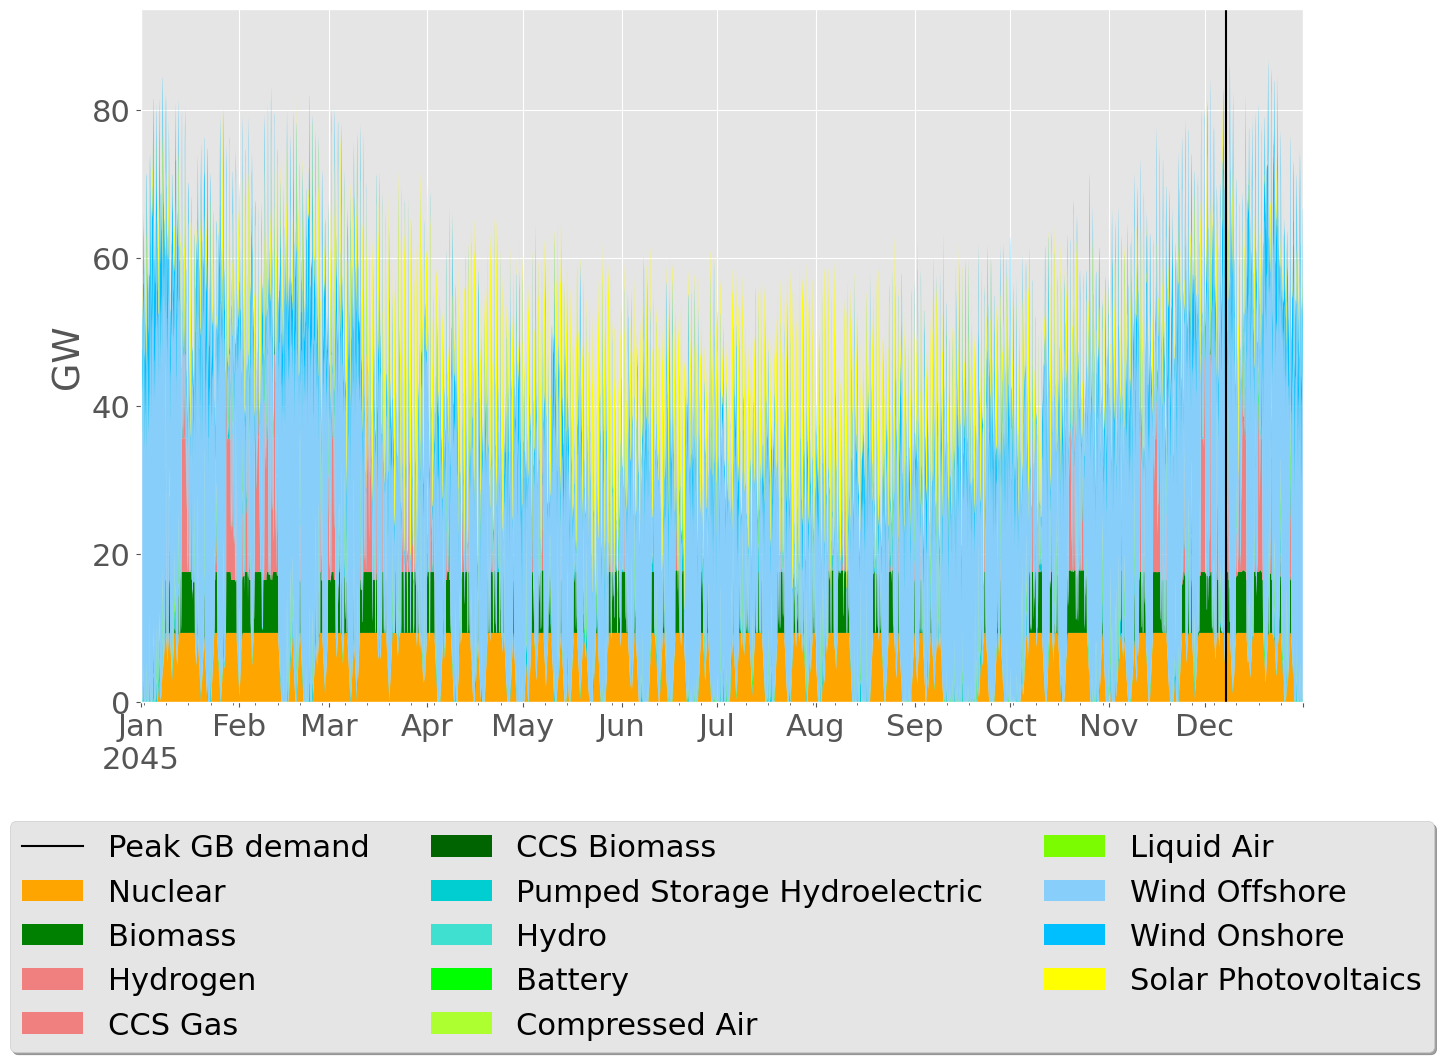

In [9]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

ax.set_ylabel("GW")

ax.set_xlabel("")

In [10]:

buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]

p_by_carrier_scotland = network.generators_t.p[df_generators_scotland.index.values].groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier_scotland = network.storage_units_t.p[df_storage_scotland.index.values].groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier_scotland[storage_by_carrier_scotland < 0] = 0

p_by_carrier_scotland = pd.concat([p_by_carrier_scotland, storage_by_carrier_scotland], axis=1)

In [11]:
network.lines_t.p0[['17', '18', '23', '24', '16']]
B6_to_scotland = network.lines_t.p0[['17', '18', '23', '24', '16']]

B6_import = B6_to_scotland.copy()
B6_export = B6_to_scotland.copy()

B6_import[B6_import > 0] = 0
B6_import = B6_import.sum(axis=1) * -1

B6_export[B6_export < 0] = 0
B6_export = B6_export.sum(axis=1) * -1
B6_export.name = 'B6 export'

snapshot
2045-01-01 00:00:00   -7927.659145
2045-01-01 01:00:00   -7540.919045
2045-01-01 02:00:00   -8104.978609
2045-01-01 03:00:00   -7530.992344
2045-01-01 04:00:00   -6309.412868
                          ...     
2045-12-31 19:00:00   -6680.117273
2045-12-31 20:00:00   -7590.547770
2045-12-31 21:00:00   -6556.402470
2045-12-31 22:00:00   -7377.782030
2045-12-31 23:00:00   -7228.940028
Name: B6 export, Length: 8760, dtype: float64


c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

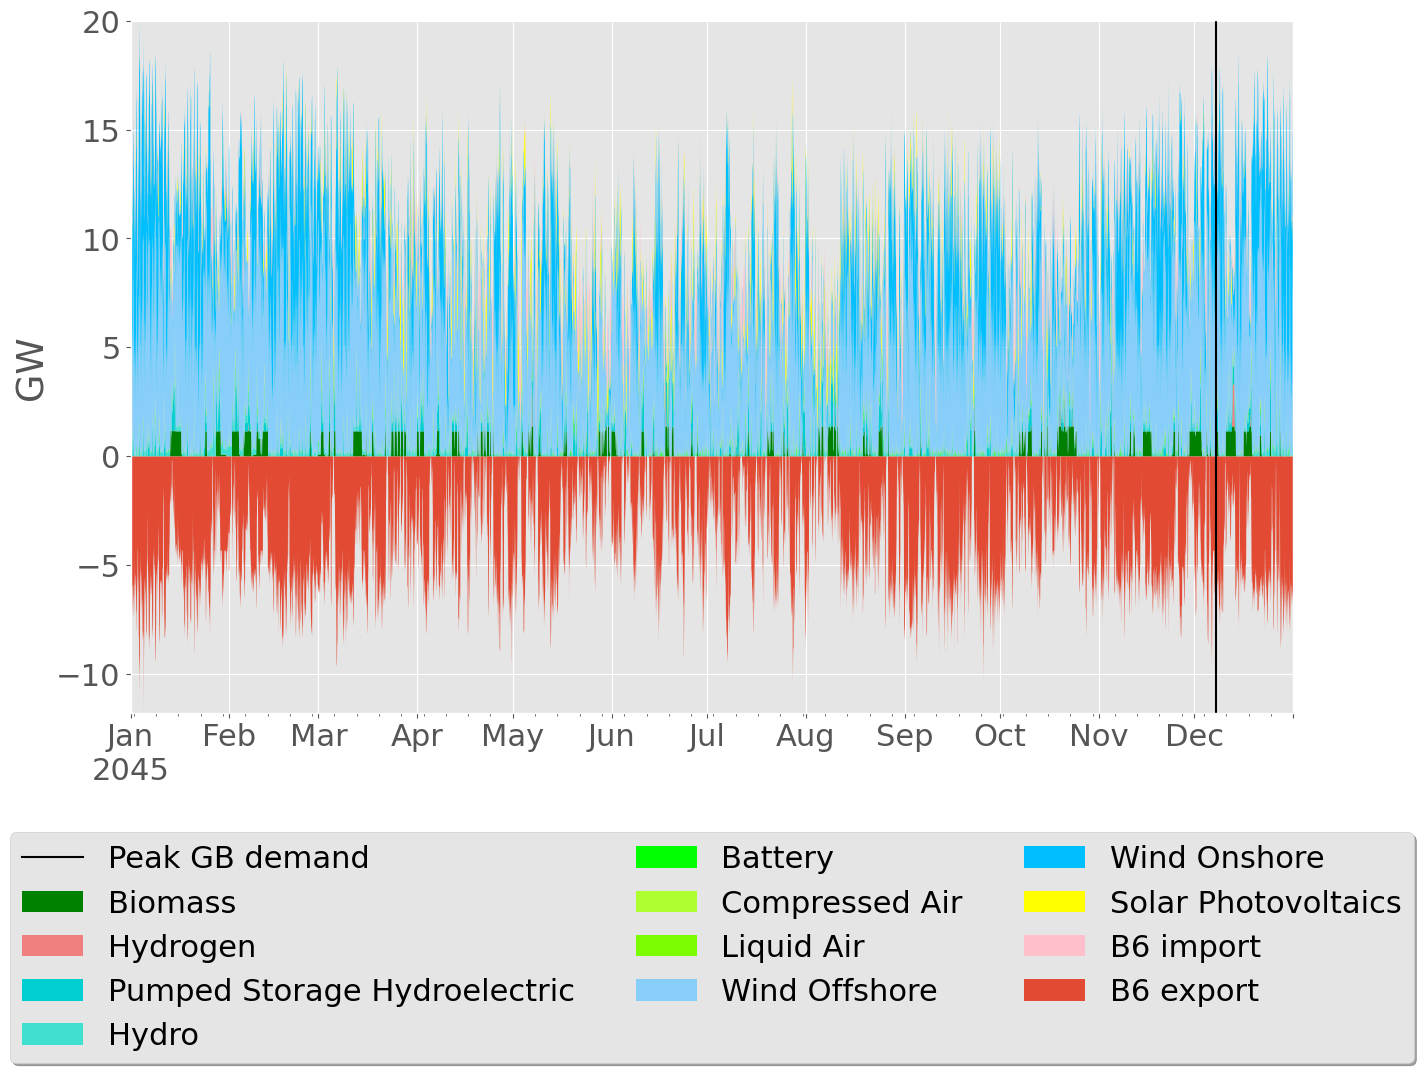

In [12]:
# group biomass stuff
p_by_carrier_scotland['Biomass'] = (
    p_by_carrier_scotland['Biomass (dedicated)'])

# add B6 flows
p_by_carrier_scotland['B6 import'] = B6_import

# rename the hydro bit
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Interconnector': 'Interconnectors Import'})

cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load', 'B6 import'
        ]

p_by_carrier_scotland = p_by_carrier_scotland[cols]

p_by_carrier_scotland.drop(
    (p_by_carrier_scotland.max()[p_by_carrier_scotland.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier_scotland / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier_scotland.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(B6_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
print(B6_export)
ax.set_ylim(B6_export.min() / 1e3, (p_by_carrier_scotland / 1e3).sum(axis=1).max())

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("GW")

ax.set_xlabel("")


## Import and export analysis

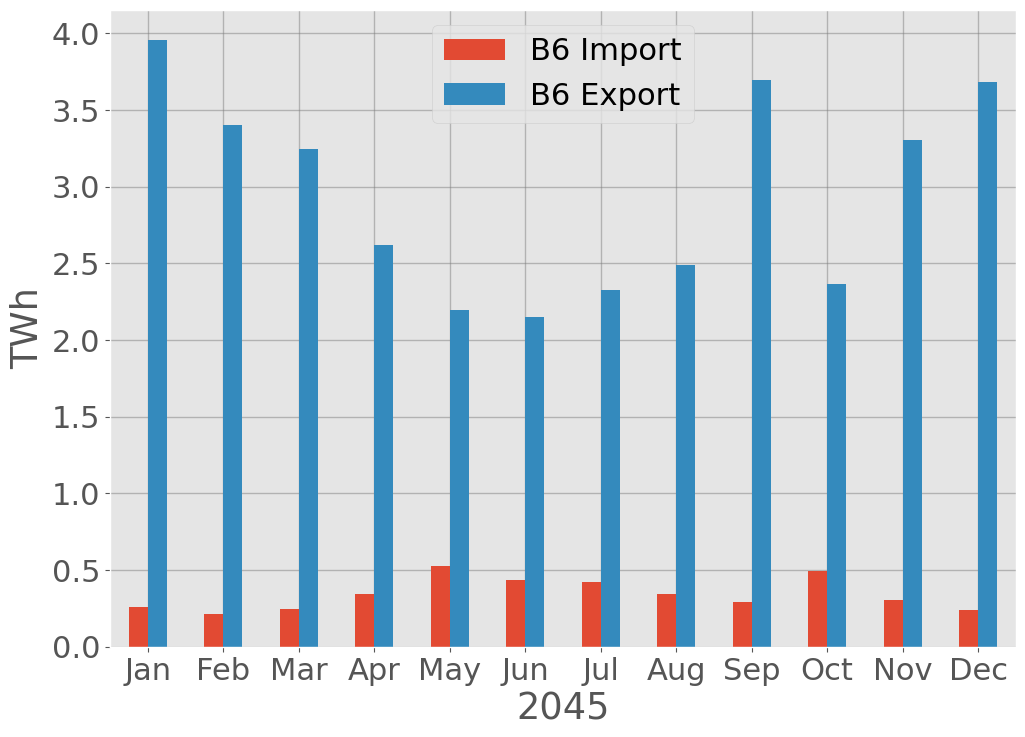

In [13]:
df_import_export = pd.concat([B6_import, B6_export * -1], axis=1) / 1000000
df_import_export.columns = ['B6 Import', 'B6 Export']
df_import_export.to_csv('import_export_2045.csv')

df_import_export = df_import_export.groupby(df_import_export.index.to_period('M')).sum()
df_import_export.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_import_export.plot(kind="bar", rot=0, figsize=(11.69, 8.27))
plt.ylabel('TWh')
plt.xlabel('2045')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)


In [14]:
print(network.lines.at['4', 's_nom'])

14949.09090909091
